# Using  FER2013 First, consider LittleVGG for Emotion Detection

### Training Emotion Detector

In [1]:
from __future__ import print_function

import os

from time import sleep

import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, ELU, Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1
from tensorflow.keras.utils import load_img, img_to_array

import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from os import listdir
from os.path import isfile, join
import re

In [2]:
cv2.__version__

'4.6.0'

In [3]:
## initializing 

In [4]:
num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 512

train_data_dir = '../Data/archive/train/'
validation_data_dir = '../Data/archive/test/'

In [5]:


# Let's use some data augmentaiton 
# train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
        rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
print(validation_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [18]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(48,48,1)))
# model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(7, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# # model.add(BatchNormalization())

model.add(Conv2D(7, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Activation("softmax"))

model.summary()
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(7, activation='softmax'))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)        

## Training our model

In [8]:
# Found 28709 images belonging to 7 classes.
# Found 7178 images belonging to 7 classes.

In [9]:
# If you want to train the same model or try other models, go for this

filepath = os.path.join("../Data/emotion_detector_models/charlie_model/initial_weights.h5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]
# if mode == "train":
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
nb_train_samples = 28709
nb_validation_samples = 7178
epochs = 250
model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

# plot_model_history(model_info)
# model.save_weights('model.h5')


/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/var/folders/tv/w6v8s7sx38q5glg08jvjkmtm0000gn/T/ipykernel_39569/332826933.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_info = model.fit_generator(


Epoch 1/250


2022-09-23 13:38:06.249735: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-23 13:38:06.568646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 1.9351 - accuracy: 0.2221

2022-09-23 13:38:16.712517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 12s 198ms/step - loss: 1.9351 - accuracy: 0.2221 - val_loss: 1.9181 - val_accuracy: 0.2469
Epoch 2/250
56/56 [==============================] - 10s 184ms/step - loss: 1.9088 - accuracy: 0.2518 - val_loss: 1.9124 - val_accuracy: 0.2475
Epoch 3/250
56/56 [==============================] - 9s 159ms/step - loss: 1.9041 - accuracy: 0.2510 - val_loss: 1.9058 - val_accuracy: 0.2475
Epoch 4/250
56/56 [==============================] - 8s 149ms/step - loss: 1.8993 - accuracy: 0.2522 - val_loss: 1.8998 - val_accuracy: 0.2489
Epoch 5/250
56/56 [==============================] - 8s 147ms/step - loss: 1.8955 - accuracy: 0.2527 - val_loss: 1.8966 - val_accuracy: 0.2518
Epoch 6/250
56/56 [==============================] - 8s 148ms/step - loss: 1.8911 - accuracy: 0.2533 - val_loss: 1.8885 - val_accuracy: 0.2542
Epoch 7/250
56/56 [==============================] - 8s 149ms/step - loss: 1.8854 - accuracy: 0.2543 - val_loss: 1.8821 - val_accuracy: 0.2556
Epoch 8/2

Epoch 55/250
56/56 [==============================] - 8s 145ms/step - loss: 1.6018 - accuracy: 0.3823 - val_loss: 1.5284 - val_accuracy: 0.4114
Epoch 56/250
56/56 [==============================] - 8s 145ms/step - loss: 1.5962 - accuracy: 0.3835 - val_loss: 1.5264 - val_accuracy: 0.4152
Epoch 57/250
56/56 [==============================] - 8s 145ms/step - loss: 1.5957 - accuracy: 0.3822 - val_loss: 1.5083 - val_accuracy: 0.4297
Epoch 58/250
56/56 [==============================] - 8s 144ms/step - loss: 1.5934 - accuracy: 0.3872 - val_loss: 1.5328 - val_accuracy: 0.4195
Epoch 59/250
56/56 [==============================] - 8s 144ms/step - loss: 1.5902 - accuracy: 0.3862 - val_loss: 1.5129 - val_accuracy: 0.4300
Epoch 60/250
56/56 [==============================] - 8s 144ms/step - loss: 1.5853 - accuracy: 0.3895 - val_loss: 1.5041 - val_accuracy: 0.4328
Epoch 61/250
56/56 [==============================] - 8s 144ms/step - loss: 1.5840 - accuracy: 0.3921 - val_loss: 1.5033 - val_accuracy:

Epoch 82/250
56/56 [==============================] - 8s 149ms/step - loss: 1.5308 - accuracy: 0.4190 - val_loss: 1.4383 - val_accuracy: 0.4637
Epoch 83/250
56/56 [==============================] - 9s 152ms/step - loss: 1.5270 - accuracy: 0.4227 - val_loss: 1.4415 - val_accuracy: 0.4604
Epoch 84/250
56/56 [==============================] - 8s 148ms/step - loss: 1.5258 - accuracy: 0.4231 - val_loss: 1.4365 - val_accuracy: 0.4675
Epoch 85/250
56/56 [==============================] - 8s 148ms/step - loss: 1.5246 - accuracy: 0.4212 - val_loss: 1.4400 - val_accuracy: 0.4580
Epoch 86/250
56/56 [==============================] - 9s 150ms/step - loss: 1.5208 - accuracy: 0.4247 - val_loss: 1.4337 - val_accuracy: 0.4657
Epoch 87/250
56/56 [==============================] - 8s 146ms/step - loss: 1.5193 - accuracy: 0.4226 - val_loss: 1.4277 - val_accuracy: 0.4675
Epoch 88/250
56/56 [==============================] - 8s 149ms/step - loss: 1.5150 - accuracy: 0.4284 - val_loss: 1.4277 - val_accuracy:

Epoch 109/250
56/56 [==============================] - 8s 145ms/step - loss: 1.4836 - accuracy: 0.4424 - val_loss: 1.4097 - val_accuracy: 0.4729
Epoch 110/250
56/56 [==============================] - 8s 144ms/step - loss: 1.4824 - accuracy: 0.4436 - val_loss: 1.3987 - val_accuracy: 0.4782
Epoch 111/250
56/56 [==============================] - 8s 144ms/step - loss: 1.4870 - accuracy: 0.4422 - val_loss: 1.4289 - val_accuracy: 0.4681
Epoch 112/250
56/56 [==============================] - 8s 145ms/step - loss: 1.4797 - accuracy: 0.4425 - val_loss: 1.3990 - val_accuracy: 0.4813
Epoch 113/250
56/56 [==============================] - 8s 144ms/step - loss: 1.4771 - accuracy: 0.4456 - val_loss: 1.3947 - val_accuracy: 0.4812
Epoch 114/250
56/56 [==============================] - 8s 145ms/step - loss: 1.4782 - accuracy: 0.4439 - val_loss: 1.3969 - val_accuracy: 0.4817
Epoch 115/250
56/56 [==============================] - 8s 145ms/step - loss: 1.4786 - accuracy: 0.4442 - val_loss: 1.3902 - val_ac

Epoch 136/250
56/56 [==============================] - 8s 144ms/step - loss: 1.4474 - accuracy: 0.4575 - val_loss: 1.3829 - val_accuracy: 0.4881
Epoch 137/250
56/56 [==============================] - 8s 147ms/step - loss: 1.4464 - accuracy: 0.4570 - val_loss: 1.3608 - val_accuracy: 0.5000
Epoch 138/250
56/56 [==============================] - 8s 145ms/step - loss: 1.4456 - accuracy: 0.4611 - val_loss: 1.3661 - val_accuracy: 0.4983
Epoch 139/250
56/56 [==============================] - 8s 144ms/step - loss: 1.4402 - accuracy: 0.4610 - val_loss: 1.3856 - val_accuracy: 0.4881
Epoch 140/250
56/56 [==============================] - 8s 144ms/step - loss: 1.4439 - accuracy: 0.4582 - val_loss: 1.3640 - val_accuracy: 0.4967
Epoch 141/250
56/56 [==============================] - 8s 144ms/step - loss: 1.4394 - accuracy: 0.4597 - val_loss: 1.3713 - val_accuracy: 0.4962
Epoch 142/250
56/56 [==============================] - 8s 147ms/step - loss: 1.4355 - accuracy: 0.4630 - val_loss: 1.3912 - val_ac

Epoch 163/250
56/56 [==============================] - 8s 145ms/step - loss: 1.4149 - accuracy: 0.4750 - val_loss: 1.3440 - val_accuracy: 0.5049
Epoch 164/250
56/56 [==============================] - 8s 147ms/step - loss: 1.4148 - accuracy: 0.4704 - val_loss: 1.3461 - val_accuracy: 0.5046
Epoch 165/250
56/56 [==============================] - 8s 145ms/step - loss: 1.4087 - accuracy: 0.4740 - val_loss: 1.3421 - val_accuracy: 0.5084
Epoch 166/250
56/56 [==============================] - 8s 146ms/step - loss: 1.4173 - accuracy: 0.4733 - val_loss: 1.3559 - val_accuracy: 0.5071
Epoch 167/250
56/56 [==============================] - 8s 148ms/step - loss: 1.4160 - accuracy: 0.4720 - val_loss: 1.3398 - val_accuracy: 0.5114
Epoch 168/250
56/56 [==============================] - 8s 150ms/step - loss: 1.4104 - accuracy: 0.4717 - val_loss: 1.3566 - val_accuracy: 0.5039
Epoch 169/250
56/56 [==============================] - 8s 144ms/step - loss: 1.4077 - accuracy: 0.4762 - val_loss: 1.3387 - val_ac

Epoch 190/250
56/56 [==============================] - 8s 149ms/step - loss: 1.3886 - accuracy: 0.4845 - val_loss: 1.3247 - val_accuracy: 0.5174
Epoch 191/250
56/56 [==============================] - 8s 147ms/step - loss: 1.3900 - accuracy: 0.4802 - val_loss: 1.3275 - val_accuracy: 0.5120
Epoch 192/250
56/56 [==============================] - 8s 148ms/step - loss: 1.3923 - accuracy: 0.4809 - val_loss: 1.3459 - val_accuracy: 0.5116
Epoch 193/250
56/56 [==============================] - 8s 144ms/step - loss: 1.3896 - accuracy: 0.4856 - val_loss: 1.3191 - val_accuracy: 0.5208
Epoch 194/250
56/56 [==============================] - 8s 148ms/step - loss: 1.3866 - accuracy: 0.4842 - val_loss: 1.3300 - val_accuracy: 0.5170
Epoch 195/250
56/56 [==============================] - 8s 145ms/step - loss: 1.3845 - accuracy: 0.4870 - val_loss: 1.3251 - val_accuracy: 0.5151
Epoch 196/250
56/56 [==============================] - 8s 146ms/step - loss: 1.3859 - accuracy: 0.4832 - val_loss: 1.3315 - val_ac

Epoch 217/250
56/56 [==============================] - 8s 146ms/step - loss: 1.3710 - accuracy: 0.4946 - val_loss: 1.3142 - val_accuracy: 0.5219
Epoch 218/250
56/56 [==============================] - 8s 145ms/step - loss: 1.3639 - accuracy: 0.4960 - val_loss: 1.3144 - val_accuracy: 0.5186
Epoch 219/250
56/56 [==============================] - 9s 151ms/step - loss: 1.3615 - accuracy: 0.4966 - val_loss: 1.2999 - val_accuracy: 0.5300
Epoch 220/250
56/56 [==============================] - 8s 146ms/step - loss: 1.3669 - accuracy: 0.4922 - val_loss: 1.3124 - val_accuracy: 0.5248
Epoch 221/250
56/56 [==============================] - 8s 149ms/step - loss: 1.3681 - accuracy: 0.4929 - val_loss: 1.3152 - val_accuracy: 0.5199
Epoch 222/250
56/56 [==============================] - 8s 145ms/step - loss: 1.3673 - accuracy: 0.4937 - val_loss: 1.2992 - val_accuracy: 0.5312
Epoch 223/250
56/56 [==============================] - 8s 147ms/step - loss: 1.3632 - accuracy: 0.4941 - val_loss: 1.3190 - val_ac

Epoch 244/250
56/56 [==============================] - 8s 145ms/step - loss: 1.3486 - accuracy: 0.5011 - val_loss: 1.3305 - val_accuracy: 0.5148
Epoch 245/250
56/56 [==============================] - 8s 147ms/step - loss: 1.3470 - accuracy: 0.5033 - val_loss: 1.3266 - val_accuracy: 0.5149
Epoch 246/250
56/56 [==============================] - 8s 147ms/step - loss: 1.3496 - accuracy: 0.5037 - val_loss: 1.2871 - val_accuracy: 0.5310
Epoch 247/250
56/56 [==============================] - 8s 146ms/step - loss: 1.3472 - accuracy: 0.5032 - val_loss: 1.2937 - val_accuracy: 0.5314
Epoch 248/250
56/56 [==============================] - 9s 151ms/step - loss: 1.3469 - accuracy: 0.5026 - val_loss: 1.2969 - val_accuracy: 0.5255
Epoch 249/250
56/56 [==============================] - 8s 145ms/step - loss: 1.3444 - accuracy: 0.5015 - val_loss: 1.2903 - val_accuracy: 0.5279
Epoch 250/250
56/56 [==============================] - 8s 147ms/step - loss: 1.3455 - accuracy: 0.5020 - val_loss: 1.3007 - val_ac

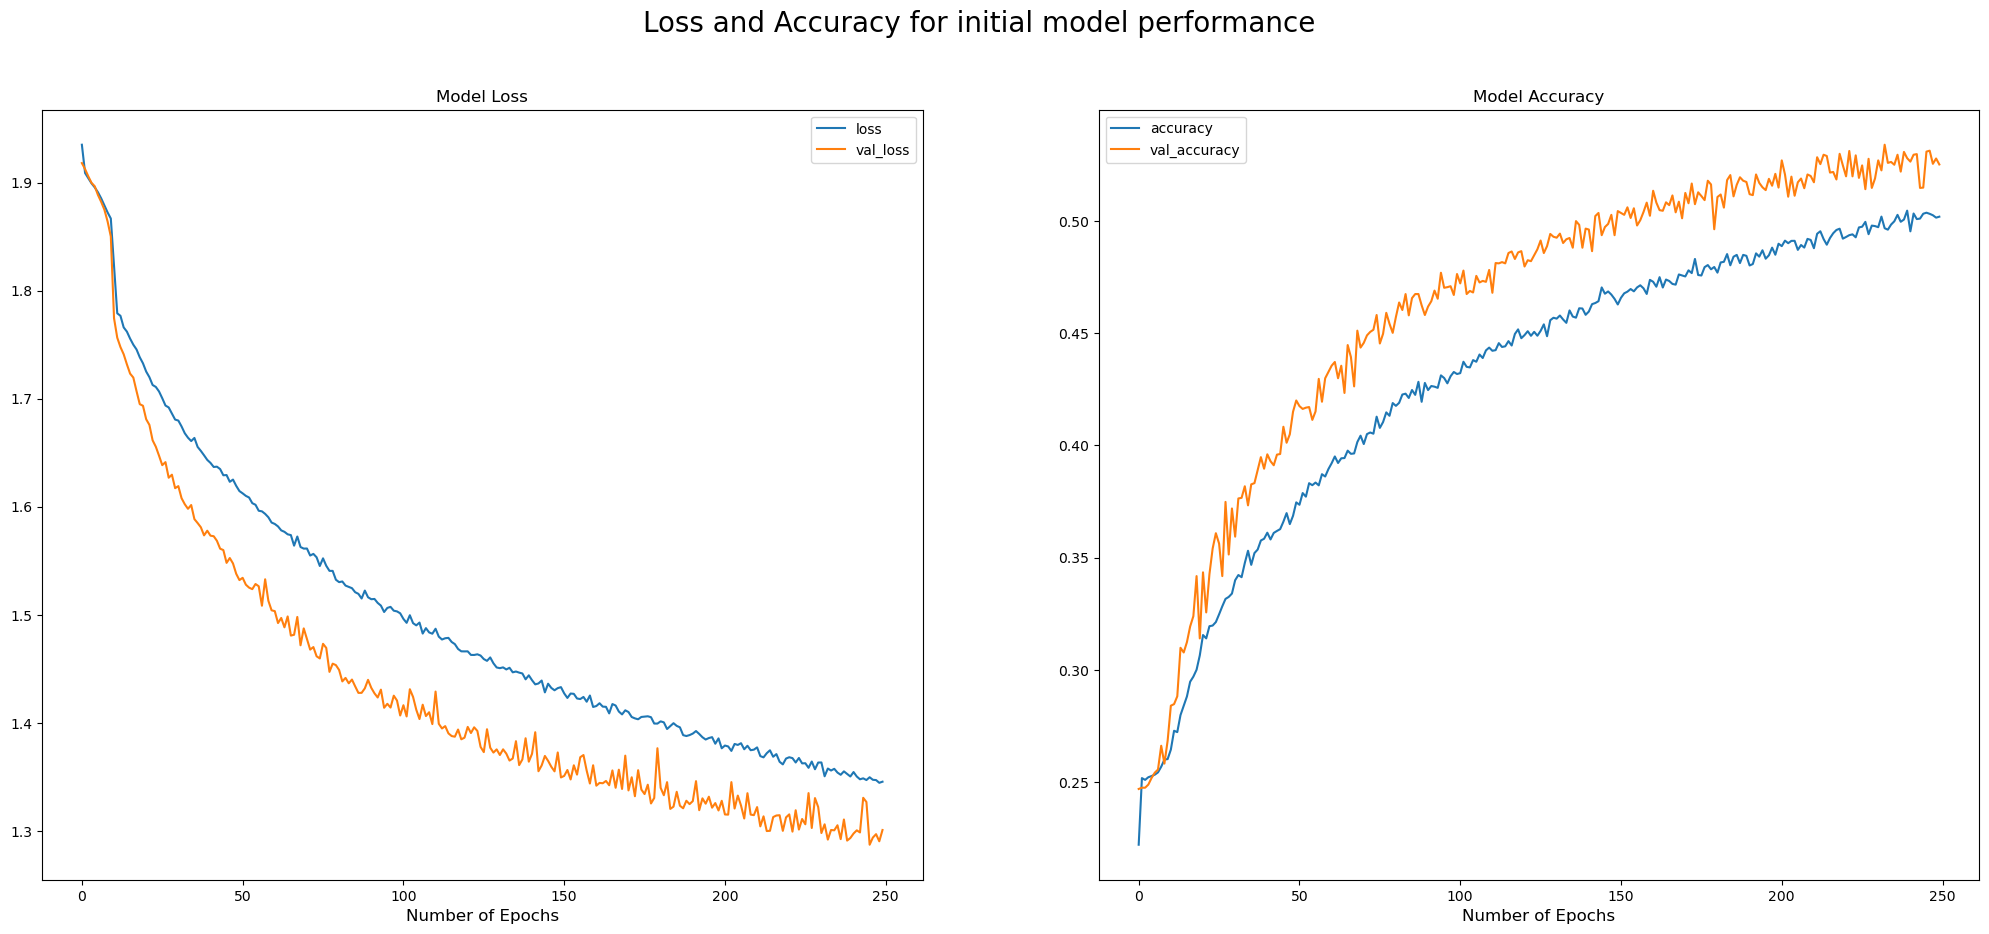

In [10]:
sigmoid_loss = model_info.history['loss']
sigmoid_accuracy = model_info.history['accuracy']
val_sigmoid_loss = model_info.history['val_loss']
val_sigmoid_accuracy = model_info.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=model_info.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=model_info.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=model_info.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=model_info.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy for initial model performance', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


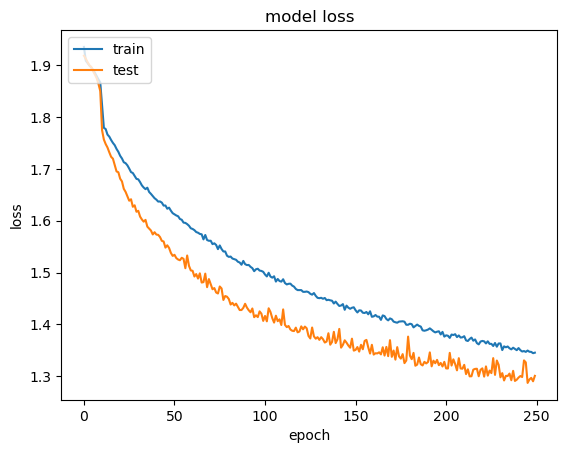

In [11]:
print(model_info.history.keys())

plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# Save previous model weights
model.save_weights('../Data/emotion_detector_models/initial_weights.h5')


In [8]:
#Apply initial model weights to the model to transfer learning from initial run
model.load_weights('../Data/emotion_detector_models/initial_weights.h5')

In [9]:
epochs2 = 150

In [20]:
model_info2 = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs2,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)


/var/folders/tv/w6v8s7sx38q5glg08jvjkmtm0000gn/T/ipykernel_48331/648369783.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_info2 = model.fit_generator(


Epoch 1/150


2022-09-26 11:18:50.361417: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-26 11:18:50.727258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - ETA: 0s - loss: 1.9339 - accuracy: 0.2243

2022-09-26 11:19:02.247287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 13s 227ms/step - loss: 1.9339 - accuracy: 0.2243 - val_loss: 1.9195 - val_accuracy: 0.2471
Epoch 2/150
56/56 [==============================] - 12s 218ms/step - loss: 1.9090 - accuracy: 0.2517 - val_loss: 1.9119 - val_accuracy: 0.2472
Epoch 3/150
56/56 [==============================] - 10s 183ms/step - loss: 1.9036 - accuracy: 0.2520 - val_loss: 1.9031 - val_accuracy: 0.2513
Epoch 4/150
56/56 [==============================] - 10s 179ms/step - loss: 1.8979 - accuracy: 0.2529 - val_loss: 1.8974 - val_accuracy: 0.2496
Epoch 5/150
56/56 [==============================] - 10s 178ms/step - loss: 1.8904 - accuracy: 0.2540 - val_loss: 1.8887 - val_accuracy: 0.2539
Epoch 6/150
56/56 [==============================] - 11s 187ms/step - loss: 1.8838 - accuracy: 0.2555 - val_loss: 1.8789 - val_accuracy: 0.2670
Epoch 7/150
56/56 [==============================] - 11s 203ms/step - loss: 1.8766 - accuracy: 0.2582 - val_loss: 1.8686 - val_accuracy: 0.2644
Epoc

56/56 [==============================] - 10s 173ms/step - loss: 1.6861 - accuracy: 0.3373 - val_loss: 1.6142 - val_accuracy: 0.3743
Epoch 29/150
56/56 [==============================] - 10s 172ms/step - loss: 1.6766 - accuracy: 0.3405 - val_loss: 1.6102 - val_accuracy: 0.3806
Epoch 30/150
56/56 [==============================] - 10s 172ms/step - loss: 1.6749 - accuracy: 0.3410 - val_loss: 1.5993 - val_accuracy: 0.3983
Epoch 31/150
56/56 [==============================] - 10s 172ms/step - loss: 1.6685 - accuracy: 0.3482 - val_loss: 1.5961 - val_accuracy: 0.3825
Epoch 32/150
56/56 [==============================] - 10s 175ms/step - loss: 1.6667 - accuracy: 0.3471 - val_loss: 1.5941 - val_accuracy: 0.3820
Epoch 33/150
56/56 [==============================] - 10s 178ms/step - loss: 1.6589 - accuracy: 0.3510 - val_loss: 1.5935 - val_accuracy: 0.3870
Epoch 34/150
56/56 [==============================] - 10s 169ms/step - loss: 1.6581 - accuracy: 0.3528 - val_loss: 1.5793 - val_accuracy: 0.391

Epoch 55/150
56/56 [==============================] - 10s 171ms/step - loss: 1.5858 - accuracy: 0.3913 - val_loss: 1.4954 - val_accuracy: 0.4364
Epoch 56/150
56/56 [==============================] - 10s 173ms/step - loss: 1.5769 - accuracy: 0.3974 - val_loss: 1.4907 - val_accuracy: 0.4382
Epoch 57/150
56/56 [==============================] - 10s 175ms/step - loss: 1.5756 - accuracy: 0.3986 - val_loss: 1.4954 - val_accuracy: 0.4379
Epoch 58/150
56/56 [==============================] - 10s 172ms/step - loss: 1.5734 - accuracy: 0.3990 - val_loss: 1.4973 - val_accuracy: 0.4365
Epoch 59/150
56/56 [==============================] - 10s 174ms/step - loss: 1.5733 - accuracy: 0.3984 - val_loss: 1.5003 - val_accuracy: 0.4365
Epoch 60/150
56/56 [==============================] - 10s 177ms/step - loss: 1.5742 - accuracy: 0.3942 - val_loss: 1.4810 - val_accuracy: 0.4417
Epoch 61/150
56/56 [==============================] - 10s 170ms/step - loss: 1.5710 - accuracy: 0.3976 - val_loss: 1.4776 - val_ac

Epoch 82/150
56/56 [==============================] - 10s 170ms/step - loss: 1.5191 - accuracy: 0.4243 - val_loss: 1.4261 - val_accuracy: 0.4707
Epoch 83/150
56/56 [==============================] - 10s 171ms/step - loss: 1.5218 - accuracy: 0.4276 - val_loss: 1.4289 - val_accuracy: 0.4713
Epoch 84/150
56/56 [==============================] - 10s 176ms/step - loss: 1.5160 - accuracy: 0.4260 - val_loss: 1.4269 - val_accuracy: 0.4676
Epoch 85/150
56/56 [==============================] - 10s 170ms/step - loss: 1.5108 - accuracy: 0.4281 - val_loss: 1.4316 - val_accuracy: 0.4683
Epoch 86/150
56/56 [==============================] - 10s 176ms/step - loss: 1.5134 - accuracy: 0.4303 - val_loss: 1.4217 - val_accuracy: 0.4739
Epoch 87/150
56/56 [==============================] - 10s 170ms/step - loss: 1.5089 - accuracy: 0.4300 - val_loss: 1.4208 - val_accuracy: 0.4713
Epoch 88/150
56/56 [==============================] - 10s 170ms/step - loss: 1.5114 - accuracy: 0.4287 - val_loss: 1.4352 - val_ac

KeyboardInterrupt: 

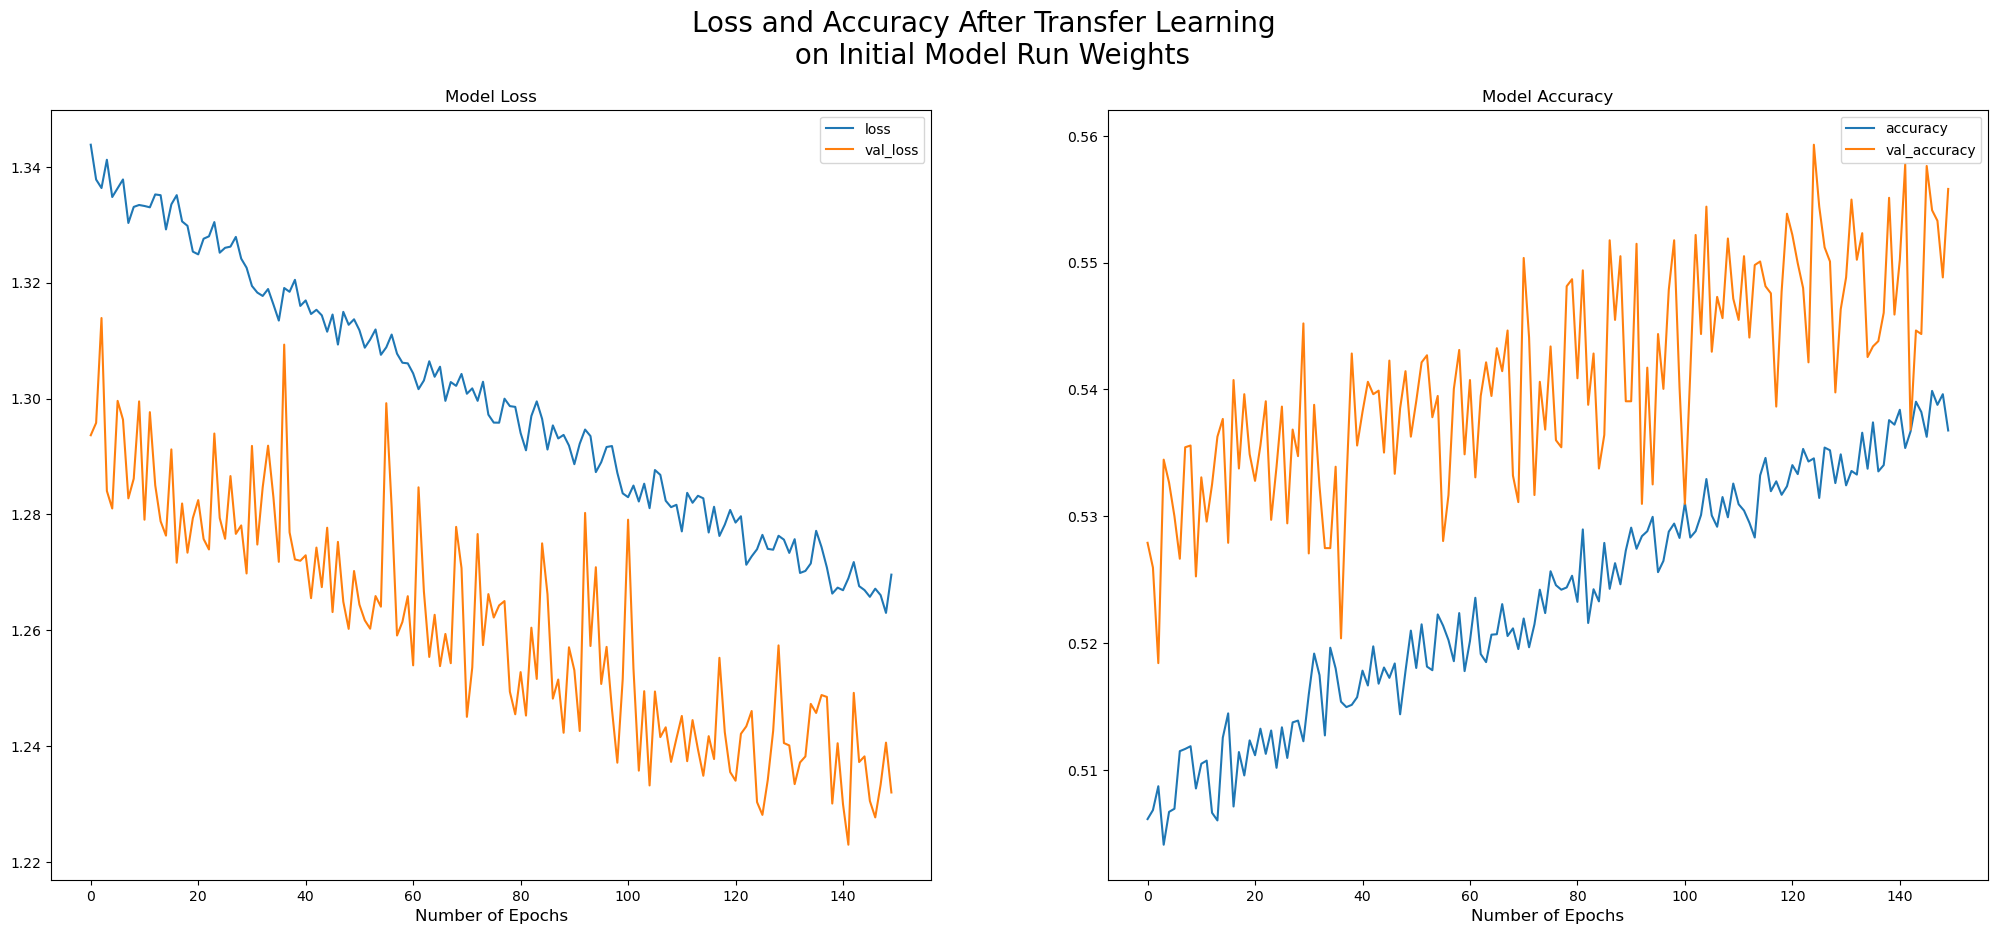

In [18]:
sigmoid_loss = model_info2.history['loss']
sigmoid_accuracy = model_info2.history['accuracy']
val_sigmoid_loss = model_info2.history['val_loss']
val_sigmoid_accuracy = model_info2.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=model_info2.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=model_info2.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=model_info2.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=model_info2.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy After Transfer Learning \n on Initial Model Run Weights', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

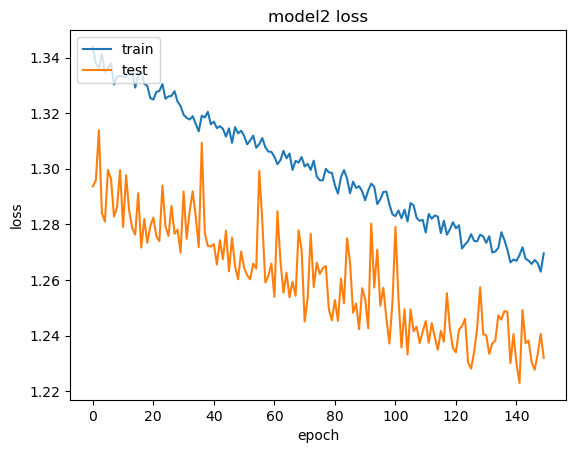

In [19]:
plt.plot(model_info2.history['loss'])
plt.plot(model_info2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Validation

In [20]:
# Found 28709 images belonging to 7 classes.
# Found 7178 images belonging to 7 classes.

nb_train_samples = 28709
nb_validation_samples = 7178

# We need to recreate our validation generator with shuffle = false
validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)



Found 7178 images belonging to 7 classes.


In [21]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


 3/15 [=====>........................] - ETA: 0s

2022-09-23 15:27:45.806753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 41ms/step


In [22]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [23]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [24]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 479    0   69   62  158  138   52]
 [  67    0    8    9   11   13    3]
 [ 175    0  210   78  175  214  172]
 [  91    0   40 1410   99   65   69]
 [  90    0   76   99  769  171   28]
 [ 175    0  112   94  326  512   28]
 [  40    0   72   47   44   17  611]]


In [25]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       angry       0.43      0.50      0.46       958
     disgust       0.00      0.00      0.00       111
        fear       0.36      0.21      0.26      1024
       happy       0.78      0.79      0.79      1774
     neutral       0.49      0.62      0.55      1233
         sad       0.45      0.41      0.43      1247
    surprise       0.63      0.74      0.68       831

    accuracy                           0.56      7178
   macro avg       0.45      0.47      0.45      7178
weighted avg       0.54      0.56      0.54      7178



/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

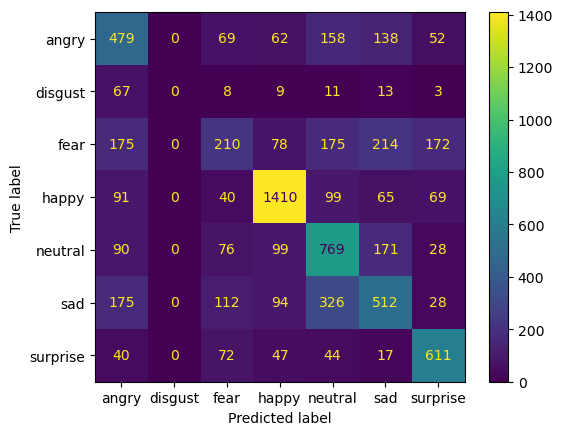

In [26]:

cnf_matrix = confusion_matrix(y_true=validation_generator.classes, y_pred=y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=classes)

disp.plot()

plt.show();

In [27]:
# saving model

model.save('../Data/emotion_detector_models/charlie_model/final_model.h5')

### Loading our saved model

In [29]:
classifier = load_model('../Data/emotion_detector_models/charlie_model/final_model.h5')

In [30]:
classifier

## Attempting to replicate above confusion matrix with saved model

In [31]:


# nb_train_samples = 28273
# nb_validation_samples = 3534
nb_train_samples = 28709
nb_validation_samples = 3589

# We need to recreate our validation generator with shuffle = false
validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)



Found 7178 images belonging to 7 classes.


In [32]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = classifier.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


 2/15 [===>..........................] - ETA: 0s

2022-09-23 15:29:38.120260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 43ms/step


In [33]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [34]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [35]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 479    0   69   62  158  138   52]
 [  67    0    8    9   11   13    3]
 [ 175    0  210   78  175  214  172]
 [  91    0   40 1410   99   65   69]
 [  90    0   76   99  769  171   28]
 [ 175    0  112   94  326  512   28]
 [  40    0   72   47   44   17  611]]


In [36]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       angry       0.43      0.50      0.46       958
     disgust       0.00      0.00      0.00       111
        fear       0.36      0.21      0.26      1024
       happy       0.78      0.79      0.79      1774
     neutral       0.49      0.62      0.55      1233
         sad       0.45      0.41      0.43      1247
    surprise       0.63      0.74      0.68       831

    accuracy                           0.56      7178
   macro avg       0.45      0.47      0.45      7178
weighted avg       0.54      0.56      0.54      7178



/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/charlielosche/miniforge3/envs/comp_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

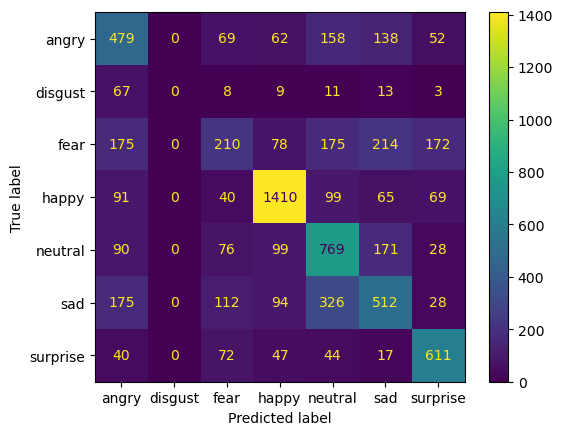

In [37]:

cnf_matrix = confusion_matrix(y_true=validation_generator.classes, y_pred=y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=classes)

disp.plot()

plt.show();

# Visualize Model Validation

### Get our class labels

In [38]:
validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 7178 images belonging to 7 classes.
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


### Let's test on some of validation images

In [39]:

def draw_test(name, pred, im, true_label):
    """NOTE: Any cell using the draw_test() function needs %matplotlib inline
    
    function generates a matplot figure containing
    the original image expanded, and the predicted class vs the actual class"""
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "Predicted - "+ pred, (20, 60) , cv2.FONT_HERSHEY_COMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "True - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_COMPLEX,1, (0,255,0), 2)
    plt.imshow(expanded_image)
    plt.show()


def getRandomImage(path, img_width, img_height):
    """function loads a random image
    from a random folder in our test path. Used alongside draw_test(), this function can generate a set of
    random images and their respective predicted vs actual classes"""
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return load_img(final_path, target_size = (img_width, img_height),color_mode="grayscale"), final_path, path_class

# dimensions of our images
img_width, img_height = 48, 48


In [40]:
# Try to load an imgage using above function
path = '../Data/archive/test/' 

img, final_path, true_label = getRandomImage(path, img_width, img_height)

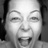

In [41]:
img

In [42]:
final_path

'../Data/archive/test/angry/PrivateTest_20571365.jpg'

In [43]:
true_label

'angry'

In [44]:
## Comenting out new compiler to avoid retraining saved model

In [45]:
# # We use a very small learning rate 
# model.compile(loss = 'categorical_crossentropy',
#               optimizer = RMSprop(learning_rate=0.001),
#               metrics = ['accuracy'])


In [46]:
files = []
predictions = []
true_labels = []

# TRYING TO UPDATE CODE

In [47]:
# predicting images
for i in range(0, 10):
    path = '../Data/archive/test/'
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    preds = classifier.predict(images, batch_size = 10)
    classes = np.argmax(preds,axis=1)
    predictions.append(classes)

1/1 [==============================] - 0s 8ms/step


2022-09-23 15:29:47.490061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 8ms/step


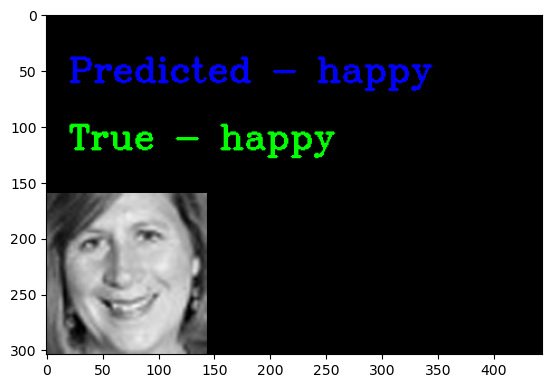

In [48]:
# Attempt generating one image first and it's class
# Any cell using the draw_test() function needs %matplotlib inline
%matplotlib inline


image = cv2.imread((files[0]))
image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
draw_test("Prediction", class_labels[predictions[0][0]], image, true_labels[0])

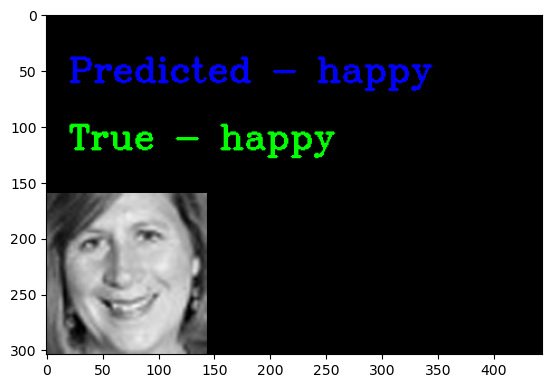

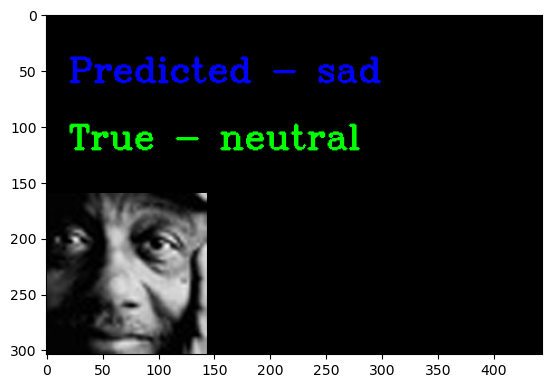

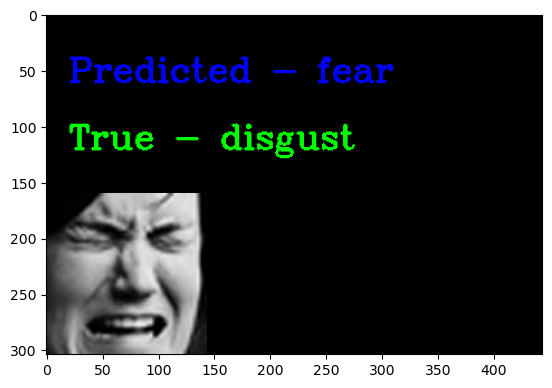

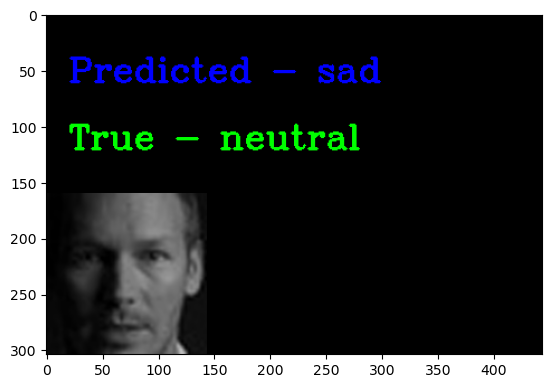

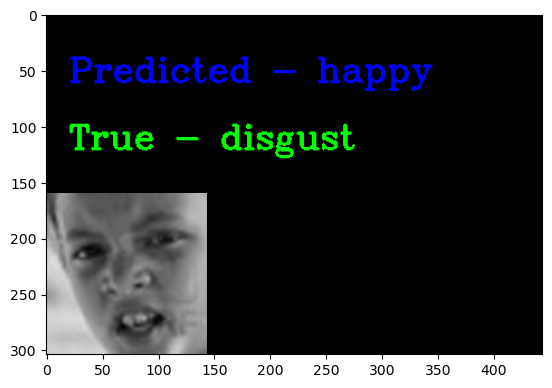

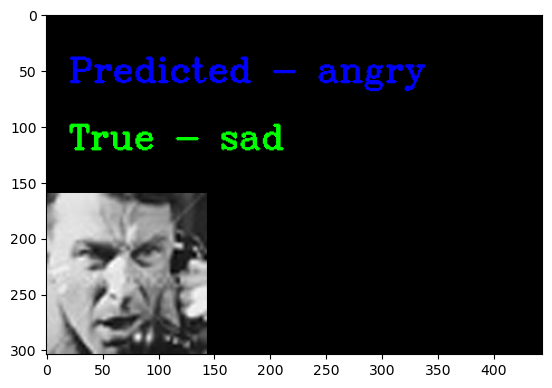

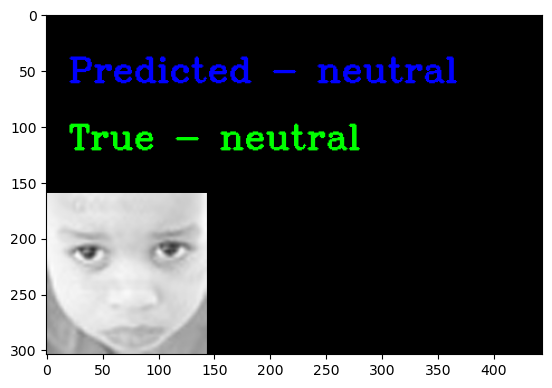

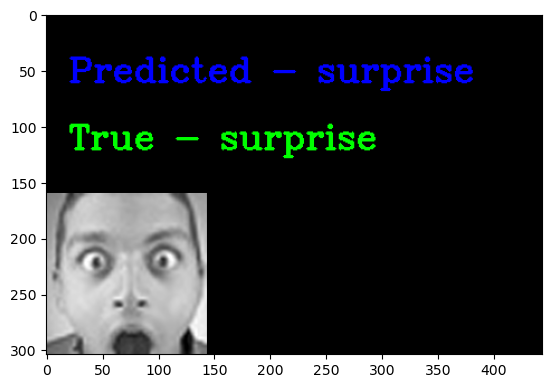

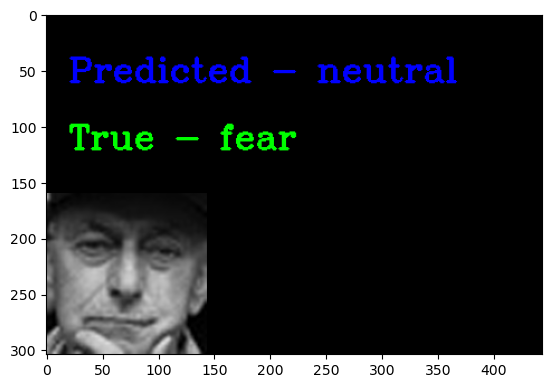

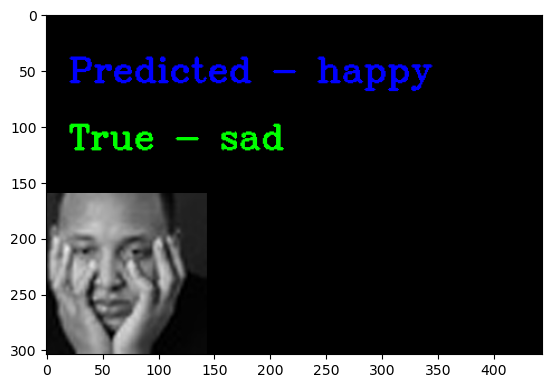

In [49]:
%matplotlib inline

for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])

### Test on a single image

In [102]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [103]:
def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if np.array_equal(faces,()):
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

In [113]:
%matplotlib inline

img = cv2.imread("../Data/unseen_images/Austin_JLin.jpeg")
rects, faces, image = face_detector(img)


1/1 [==============================] - 0s 11ms/step


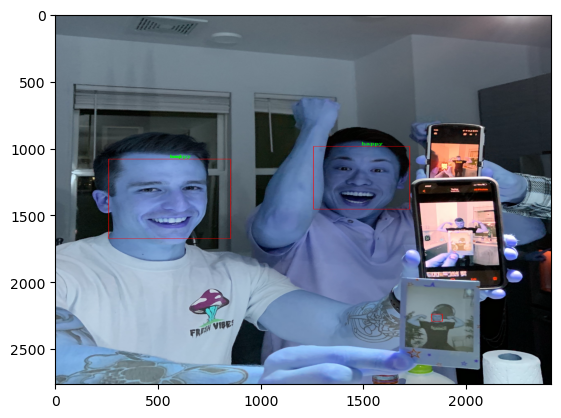

1/1 [==============================] - 0s 10ms/step


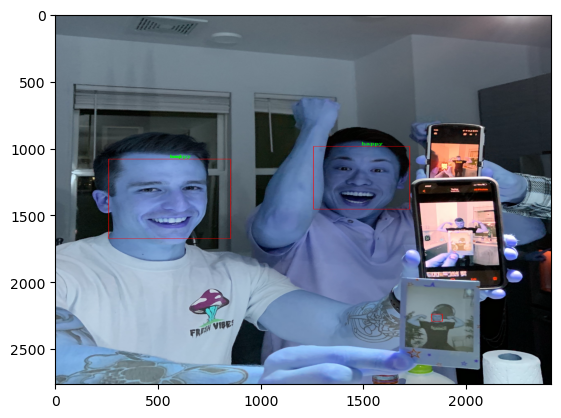

1/1 [==============================] - 0s 10ms/step


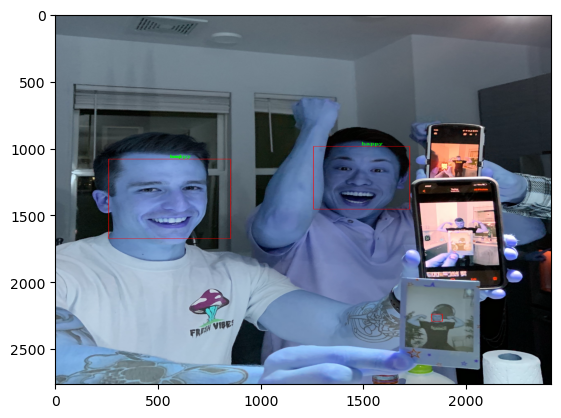

In [115]:

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_COMPLEX,1, (0,255,0), 2)
    
    #Show the image with matplotlib
    plt.imshow(image, aspect='auto')
    plt.show()

### Let's try this on our webcam


In [53]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if np.array_equal(faces,()):
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


In [54]:
cap.release()
cv2.destroyAllWindows()      